In [83]:
import polars as pl
from datetime import datetime
from dateutil.relativedelta import relativedelta
from datetime import datetime,date
from bokeh.plotting import figure, show, curdoc
from bokeh.transform import linear_cmap
from bokeh.palettes import Paired
from bokeh.models import ColumnDataSource, HoverTool, CrosshairTool,Span,Range1d,LinearAxis,Select,DataTable,TableColumn,StringEditor,DateFormatter
from bokeh.io import output_notebook

#output_notebook()
curdoc().theme = 'light_minimal'
today=date.today().replace(day=1)

#fn,reg,loc,gb='APAC','Region','South Pacific','CatalogNumber'
fn,reg,loc,gb='APAC','Region','South Pacific','CatalogNumber'
#fn,reg,loc,gb='APAC','Country','CHINA','CatalogNumber'
#fn,reg,loc,gb='Trauma and Extremities','Country','UNITED STATES','CatalogNumber'
#fn,reg,loc,gb='Europe','Stryker Group Region','EUROPE','IBP Level 7'
sk=300

df=pl.read_parquet(f"{fn}.parquet")
df=df.filter(pl.col('SALES_DATE')<=datetime(today.year,today.month,1)-relativedelta(months=1))
#df=df.filter(pl.col('Franchise')=='Trauma and Extremities')
df=df.filter(pl.col('Franchise')=='Instruments')
#df=df.filter(pl.col('Franchise')=='Joint Replacement')
df=df.filter(pl.col(reg)==loc)[['Region',gb,'SALES_DATE','`Act Orders Rev','Act Orders Rev Val','`Fcst DF Final Rev','Fcst DF Final Rev Val','L2 Stat Final Rev']]
df=df.group_by(['Region',gb,'SALES_DATE']).sum()
df = df.with_columns((pl.col('Act Orders Rev Val')/pl.col('`Act Orders Rev')).alias('ASP'))
cc=df.drop_nulls().group_by(gb).sum().sort('`Act Orders Rev',descending=True)[[gb,'`Act Orders Rev']]
cc=cc.filter(pl.col('CatalogNumber')!='107120-HIP')

In [84]:
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, RollingMax
from mlforecast.target_transforms import Differences
from utilsforecast.plotting import plot_series
from utilsforecast.losses import rmse
models = [
    #lgb.LGBMRegressor(random_state=0, verbosity=-1,),
    LinearRegression(),
    #RandomForestRegressor(),
    #xgb.XGBRegressor(),
]
tdf=df.rename({'SALES_DATE':'ds','`Act Orders Rev':'y','CatalogNumber':'unique_id'})
tdf=tdf.fill_nan(0)
tdf=tdf.fill_null(0)
fcst = MLForecast(models=models,freq='1mo',lags=[3,12], lag_transforms={
        4: [RollingMean(window_size=3)]},target_transforms=[Differences([1])], date_features=['month'])

wd=pl.read_excel('working days.xlsx')
wd=wd.with_columns(pl.col('Date').cast(pl.Datetime('us')))
tdf=tdf.join(wd,left_on='ds',right_on='Date',how='left')
def evaluate_cv(df):
    #return rmse(df, models=['LGBMRegressor','LinearRegression','RandomForestRegressor','XGBRegressor',],id_col='cutoff')
    return rmse(df, models=['LinearRegression'],id_col='cutoff')
tdf=tdf.filter(pl.col('unique_id').is_in(cc['CatalogNumber'][:20]))['ds','y','unique_id','L2 Stat Final Rev'].sort('ds')
fdf=tdf.filter(pl.col('ds')<=datetime(today.year,today.month,1)-relativedelta(months=4))['ds','y','unique_id'].sort('ds')

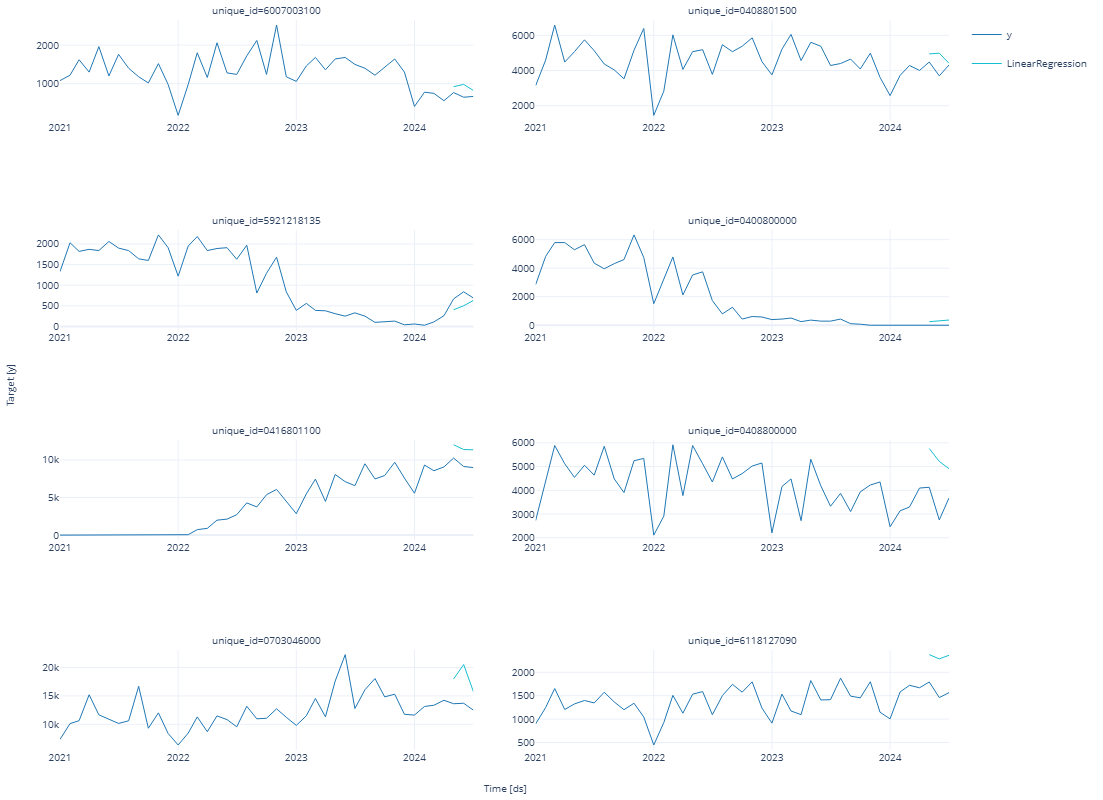

In [85]:
#pdf=tdf.join(pred,on=['ds','unique_id'],how='left')
fcst.fit(fdf,fitted=True)
pred=fcst.predict(3)
f=plot_series(df=tdf,forecasts_df=pred,engine='plotly',plot_random=0)
f.show()

In [86]:
cv_result2 = fcst.cross_validation(fdf,n_windows=4,h=3,static_features=[])
evaluate_cv(cv_result2).to_pandas().style.background_gradient(axis=1)

,cutoff,LinearRegression
0,2023-04-01 00:00:00,2301.339486
1,2023-07-01 00:00:00,1841.472417
2,2023-10-01 00:00:00,1984.634633
3,2024-01-01 00:00:00,1427.903159


In [87]:
evaluate_cv(cv_result2).mean()

cutoff,LinearRegression
datetime[μs],f64
2023-08-16 06:00:00,1888.837424


In [88]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF

In [89]:
sf = StatsForecast(models = [AutoARIMA(season_length = 12)],freq = '1mo')
cv_result1=sf.cross_validation(df=fdf,h=3,n_windows=4)
rmse(cv_result1, models=['AutoARIMA'],id_col='cutoff')
#ap=sf.predict(h=4, level=[95])

cutoff,AutoARIMA
datetime[μs],f32
2023-10-01 00:00:00,1320.966919
2023-11-01 00:00:00,1365.287598
2023-12-01 00:00:00,1175.659912
2024-01-01 00:00:00,1270.51001


In [92]:
rmse(cv_result1, models=['AutoARIMA'],id_col='cutoff').mean()

cutoff,AutoARIMA
datetime[μs],f32
2023-11-16 00:00:00,1283.106079


In [97]:
cv_result1

unique_id,ds,cutoff,y,AutoARIMA
str,datetime[μs],datetime[μs],f32,f32
"""0210114100""",2023-11-01 00:00:00,2023-10-01 00:00:00,6101.987793,6286.069336
"""0210114100""",2023-12-01 00:00:00,2023-10-01 00:00:00,4727.990723,4678.072754
"""0210114100""",2024-01-01 00:00:00,2023-10-01 00:00:00,4469.991211,3994.073975
"""0210114100""",2023-12-01 00:00:00,2023-11-01 00:00:00,4727.990723,4597.391602
"""0210114100""",2024-01-01 00:00:00,2023-11-01 00:00:00,4469.991211,3913.393066
…,…,…,…,…
"""6118127090""",2024-02-01 00:00:00,2023-12-01 00:00:00,1580.0,1533.0
"""6118127090""",2024-03-01 00:00:00,2023-12-01 00:00:00,1721.0,1173.0
"""6118127090""",2024-02-01 00:00:00,2024-01-01 00:00:00,1580.0,1640.568481


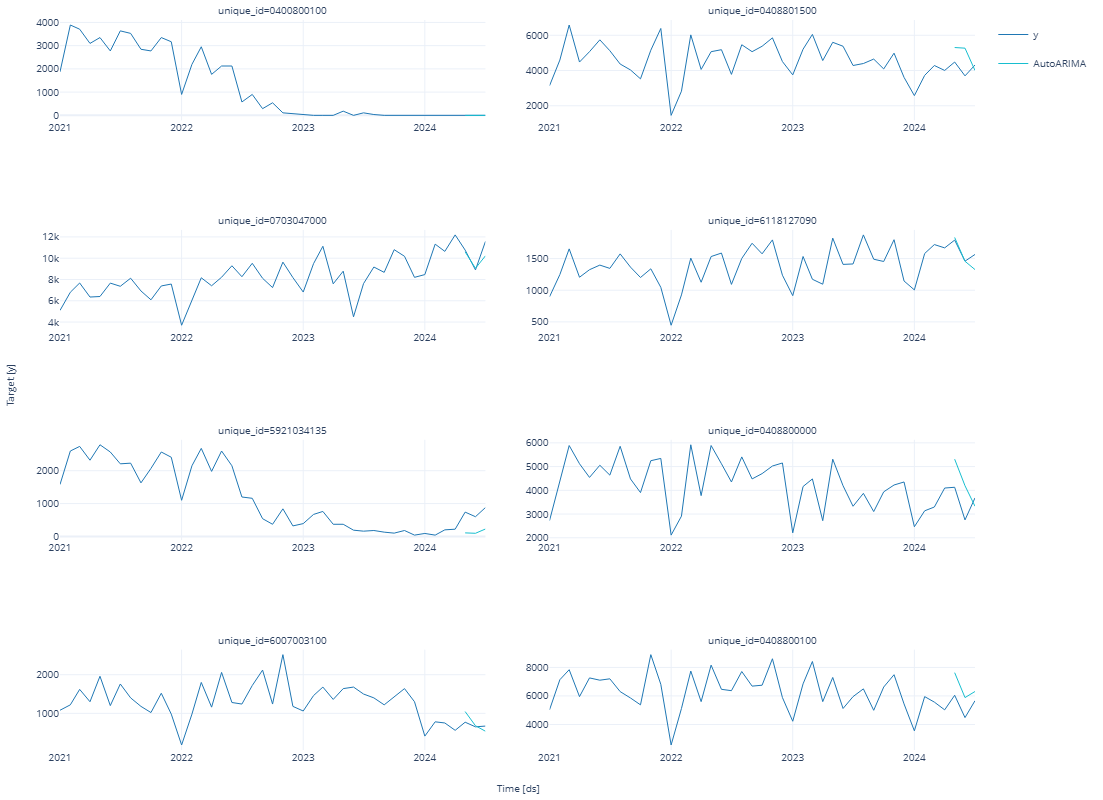

In [98]:
sf.fit(fdf)
pred=sf.predict(3)
f=plot_series(df=tdf,forecasts_df=pred,engine='plotly',plot_random=0)
f.show()

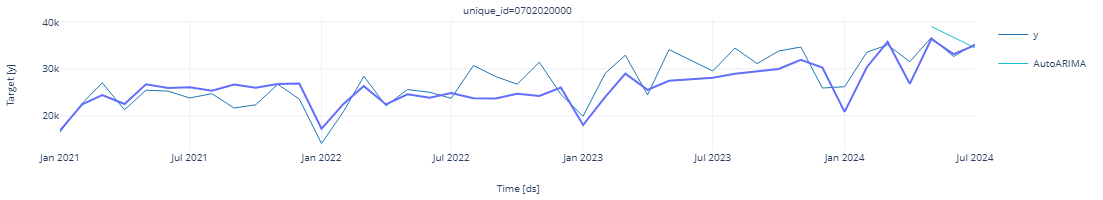

In [99]:
import plotly.graph_objects as go
import plotly.express as px
f=plot_series(df=tdf,forecasts_df=pred,engine='plotly',ids=['0702020000'])
f.add_traces(px.line(tdf.filter(pl.col('unique_id')=='0702020000'),x='ds',y='L2 Stat Final Rev').data)

In [11]:
p1=pred.join(tdf,on=['ds','unique_id'],how='left')
p1=p1.filter(pl.col('ds')<=datetime(today.year,today.month,1)-relativedelta(months=1))
p1

unique_id,ds,AutoARIMA,y,L2 Stat Final Rev
str,datetime[μs],f32,f64,f64
"""0210114100""",2024-05-01 00:00:00,7544.804688,6137.987724,5406.026359
"""0210114100""",2024-06-01 00:00:00,7136.389648,4673.990652,6174.019059
"""0210114100""",2024-07-01 00:00:00,3285.980713,5015.989968,5065.411019
"""0400800000""",2024-05-01 00:00:00,17.504808,0.0,0.0
"""0400800000""",2024-06-01 00:00:00,16.484671,0.0,0.0
…,…,…,…,…
"""6007003100""",2024-06-01 00:00:00,678.012573,650.0,707.280428
"""6007003100""",2024-07-01 00:00:00,535.943359,670.0,772.466624
"""6118127090""",2024-05-01 00:00:00,1833.37793,1792.0,1620.040119


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np
sc=[]
for s in p1['unique_id'].unique():
    for d in p1['ds'].unique():
        td={'unique_id':s,'ds':d,'AutoARIMA':np.sqrt(mean_squared_error(p1.filter(pl.col('unique_id')==s).filter(pl.col('ds')==d)['AutoARIMA'],p1.filter(pl.col('unique_id')==s).filter(pl.col('ds')==d)['y'])),
                                                     'L2 Stat':np.sqrt(mean_squared_error(p1.filter(pl.col('unique_id')==s).filter(pl.col('ds')==d)['L2 Stat Final Rev'],p1.filter(pl.col('unique_id')==s).filter(pl.col('ds')==d)['y']))}
        sc.append(td)

In [14]:
sdf=pl.DataFrame(sc)
sdf['unique_id'].mean()

In [20]:
from dtale import show as sh
sh(sdf.to_pandas())